In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
%matplotlib inline

## Charles Dickens
### Oliver Twist

In [2]:
BODY_START = 151
BODY_END = 18831
CHAP_PAT = r'^\s*(?:CHAPTER).*$'
PARA_PAT = r'\n\n+'
SENT_PAT = r'([.;?!"“”]+)'
TOKEN_PAT = r'([\W_]+)'
src_file = 'data/Oliver_Twist.txt'

In [3]:
lines = open(src_file, 'r', encoding='utf-8').readlines()

In [4]:
lines = lines[BODY_START - 1 : BODY_END + 1]

In [5]:
lines[:10]

['CHAPTER I\n',
 '\n',
 'TREATS OF THE PLACE WHERE OLIVER TWIST WAS BORN AND OF THE\n',
 'CIRCUMSTANCES ATTENDING HIS BIRTH\n',
 '\n',
 'Among other public buildings in a certain town, which for many reasons\n',
 'it will be prudent to refrain from mentioning, and to which I will\n',
 'assign no fictitious name, there is one anciently common to most towns,\n',
 'great or small: to wit, a workhouse; and in this workhouse was born; on\n',
 'a day and date which I need not trouble myself to repeat, inasmuch as\n']

In [6]:
df = pd.DataFrame({'line_str':lines})
df.index.name = 'line_id'

In [7]:
df.head()

,line_str
line_id,
0,CHAPTER I\n
1,\n
2,TREATS OF THE PLACE WHERE OLIVER TWIST WAS BOR...
3,CIRCUMSTANCES ATTENDING HIS BIRTH\n
4,\n


In [8]:
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# nltk.download('tagsets')
# nltk.download('wordnet')

In [9]:
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

In [10]:
def text_to_tokens(
                   src_file,
                   body_start=0, 
                   body_end=-1, 
                   chap_pat=r'^\s*Chapter.*$', 
                   para_pat=r'\n\n+', 
                   sent_pat=r'([.;?!"“”]+)', 
                   token_pat=r'([\W_]+)'):

    # Text to lines
    lines = open(src_file, 'r', encoding='utf-8').readlines()
    lines = lines[body_start - 1 : body_end + 1]
    df = pd.DataFrame({'line_str':lines})
    df.index.name = 'line_id'
    del(lines)
    
    # FIX CHARACTERS TO IMPROVE TOKENIZATION
    df.line_str = df.line_str.str.replace('—', ' — ')
    df.line_str = df.line_str.str.replace('-', ' - ')

    # Lines to Chapters
    mask = df.line_str.str.match(chap_pat)
    df.loc[mask, 'chap_id'] = df.apply(lambda x: x.name, 1)
    df.chap_id = df.chap_id.ffill().astype('int')
    chap_ids = df.chap_id.unique().tolist()
    df['chap_num'] = df.chap_id.apply(lambda x: chap_ids.index(x))
    chaps = df.groupby('chap_num')\
        .apply(lambda x: ''.join(x.line_str))\
        .to_frame()\
        .rename(columns={0:'chap_str'})
    del(df)

    # Chapters to Paragraphs
    paras = chaps.chap_str.str.split(para_pat, expand=True)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'para_str'})
    paras.index.names = PARAS
    paras.para_str = paras.para_str.str.strip()
    paras.para_str = paras.para_str.str.replace(r'\n', ' ')
    paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
    paras = paras[~paras.para_str.str.match(r'^\s*$')]
    del(chaps)

    # Paragraphs to Sentences
#     sents = paras.para_str.str.split(sent_pat, expand=True)\
    sents = paras.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    sents.index.names = SENTS
    del(paras)

    # Sentences to Tokens
#     tokens = sents.sent_str.str.split(token_pat, expand=True)\
    tokens = sents.sent_str\
        .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    tokens.index.names = OHCO
    del(sents)
    
    tokens['pos'] = tokens.pos_tuple.apply(lambda x: x[1])
    tokens['token_str'] = tokens.pos_tuple.apply(lambda x: x[0])
    tokens = tokens.drop('pos_tuple', 1)

    # Tag punctuation and numbers
    tokens['punc'] = tokens.token_str.str.match(r'^[\W_]*$').astype('int')
    tokens['num'] = tokens.token_str.str.match(r'^.*\d.*$').astype('int')
    
    # Extract vocab with minimal normalization
    WORDS = (tokens.punc == 0) & (tokens.num == 0)
    tokens.loc[WORDS, 'term_str'] = tokens.token_str.str.lower()\
        .str.replace(r'["_*.]', '')
    
    vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
        .reset_index()\
        .rename(columns={'index':'term_str', 'term_str':'n'})
    vocab = vocab.sort_values('term_str').reset_index(drop=True)
    vocab.index.name = 'term_id'
    
    # Get priors for V
    vocab['p'] = vocab.n / vocab.n.sum()
    
    # Add stems
    stemmer = nltk.stem.porter.PorterStemmer()
    vocab['port_stem'] = vocab.term_str.apply(lambda x: stemmer.stem(x))
    
    # Define stopwords
    sw = pd.DataFrame({'x':1}, index=nltk.corpus.stopwords.words('english'))
    vocab['stop'] = vocab.term_str.map(sw.x).fillna(0).astype('int')
    del(sw)
            
    # Add term_ids to tokens 
    tokens['term_id'] = tokens['term_str'].map(vocab.reset_index()\
        .set_index('term_str').term_id).fillna(-1).astype('int')

    return tokens, vocab

def get_docs(tokens, div_names, doc_str = 'term_id', sep='', flatten=False, 
             index_only=False):
    
    if not index_only:
        docs = tokens.groupby(div_names)[doc_str]\
          .apply(lambda x: x.str.cat(sep=sep))
        docs.columns = ['doc_content']
    else:
        docs = tokens.groupby(div_names)[doc_str].apply(lambda x: x.tolist())

    if flatten:
        docs = docs.reset_index().drop(div_names, 1)
    
    return docs

def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

In [11]:
cfg = dict(
    src_file = src_file,
    body_start = 151,
    body_end = 18831,
    chap_pat = r'^\s*(?:CHAPTER).*$'
)
OT_K, OT_V = text_to_tokens(**cfg)

In [12]:
OT_K.head()

pos token_str  punc  num term_str  \
chap_num para_num sent_num token_num                                      
0        0        0        0           NN   CHAPTER     0    0  chapter   
                           1          PRP         I     0    0        i   
         1        0        0           NN    TREATS     0    0   treats   
                           1           IN        OF     0    0       of   
                           2          NNP       THE     0    0      the   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             1916  
                           1             4876  
         1        0        0             9659  
                           1             6506  
                           2             9383

In [13]:
OT_K = OT_K.loc[OT_K.term_id >= 0]

In [14]:
OT_K.head()

pos token_str  punc  num term_str  \
chap_num para_num sent_num token_num                                      
0        0        0        0           NN   CHAPTER     0    0  chapter   
                           1          PRP         I     0    0        i   
         1        0        0           NN    TREATS     0    0   treats   
                           1           IN        OF     0    0       of   
                           2          NNP       THE     0    0      the   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             1916  
                           1             4876  
         1        0        0             9659  
                           1             6506  
                           2             9383

In [15]:
OT_V.head()

,term_str,n,p,port_stem,stop
term_id,,,,,
0,''cause,1,0.000006,''caus,0
1,''cod,1,0.000006,''cod,0
2,'a,1,0.000006,'a,0
3,'about,4,0.000025,'about,0
4,'add,1,0.000006,'add,0


In [16]:
WORDS = (OT_K.punc == 0) & (OT_K.num == 0) & OT_K.term_id.isin(OT_V[OT_V.stop==0].index)

In [17]:
BOW = OT_K[WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()

In [18]:
DTM = BOW.unstack().fillna(0)

In [19]:
DTM.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,10574,10575,10576,10577,10582,10583,10584,10585,10586,10587
chap_num,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [20]:
alpha = .000001
alpha_sum = alpha * OT_V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [21]:
N_docs = DTM.shape[0]
OT_V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / OT_V[OT_V.stop==0]['df'])

In [22]:
TFIDF.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,10574,10575,10576,10577,10582,10583,10584,10585,10586,10587
chap_num,,,,,,,,,,,,,,,,,,,,,
0,1.041420e-08,1.041420e-08,1.041420e-08,6.777907e-09,1.041420e-08,1.041420e-08,7.532506e-09,1.041420e-08,1.041420e-08,1.970990e-03,...,5.714359e-09,8.596054e-09,8.596054e-09,1.041420e-08,5.310017e-09,6.192594e-09,1.041420e-08,1.041420e-08,8.596054e-09,1.041420e-08
1,2.785939e-09,2.785939e-09,2.785939e-09,1.813182e-09,2.785939e-09,2.785939e-09,2.015047e-09,2.785939e-09,2.785939e-09,5.272664e-04,...,1.528668e-09,2.299560e-09,2.299560e-09,2.785939e-09,1.420503e-03,1.656603e-09,2.785939e-09,2.785942e-03,2.299560e-09,2.785939e-09
2,3.460957e-09,3.460957e-09,3.460957e-09,2.252506e-09,3.460957e-09,3.460957e-09,2.503282e-09,3.460957e-09,3.460957e-09,6.550195e-10,...,1.899056e-09,2.856731e-09,2.856731e-09,3.460957e-09,1.764683e-03,2.057988e-09,3.460957e-09,3.460957e-09,2.856731e-09,3.460957e-09
3,4.039406e-09,4.039406e-09,4.039406e-09,2.628979e-09,4.039406e-09,4.039406e-09,2.921669e-09,4.039406e-09,4.039406e-09,7.644974e-04,...,2.216456e-09,3.334193e-09,3.334193e-09,4.039406e-09,2.059622e-09,2.401951e-09,4.039406e-09,4.039406e-09,3.334193e-09,4.039406e-09
4,2.653030e-09,2.653030e-09,2.653030e-09,1.726680e-09,2.653030e-09,2.653030e-09,1.918915e-09,2.653030e-09,2.653030e-09,1.506335e-03,...,1.455740e-09,2.189855e-09,2.189855e-09,2.653030e-09,1.352735e-03,1.577571e-09,2.653030e-09,2.653030e-09,2.189855e-09,2.653030e-09


In [23]:
THM = -(TF * np.log2(TF))
TFTH = TF.apply(lambda x: x * THM.sum(), 1)

In [24]:
TFTH.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,10574,10575,10576,10577,10582,10583,10584,10585,10586,10587
chap_num,,,,,,,,,,,,,,,,,,,,,
0,9.927679e-12,9.927679e-12,1.307692e-11,5.108897e-11,1.037726e-11,1.859920e-11,3.651559e-11,1.449805e-11,2.217880e-11,4.250079e-04,...,9.623466e-11,2.708313e-11,2.286588e-11,1.382180e-11,8.463474e-11,5.331645e-11,1.168158e-11,9.734478e-12,2.740846e-11,2.391432e-11
1,2.655788e-12,2.655788e-12,3.498252e-12,1.366699e-11,2.776056e-12,4.975536e-12,9.768412e-12,3.878425e-12,5.933127e-12,1.136954e-04,...,2.574407e-11,7.245102e-12,6.116932e-12,3.697517e-12,2.264096e-05,1.426287e-11,3.124982e-12,2.604107e-06,7.332133e-12,6.397404e-12
2,3.299271e-12,3.299271e-12,4.345859e-12,1.697842e-11,3.448679e-12,6.181081e-12,1.213524e-11,4.818147e-12,7.370691e-12,1.412430e-10,...,3.198172e-11,9.000551e-12,7.599032e-12,4.593405e-12,2.812674e-05,1.771869e-11,3.882147e-12,3.235064e-12,9.108669e-12,7.947460e-12
3,3.850697e-12,3.850697e-12,5.072207e-12,1.981612e-11,4.025076e-12,7.214160e-12,1.416348e-11,5.623430e-12,8.602596e-12,1.648499e-04,...,3.732700e-11,1.050486e-11,8.869100e-12,5.361127e-12,3.282768e-11,2.068011e-11,4.530992e-12,3.775759e-12,1.063105e-11,9.275763e-12
4,2.529088e-12,2.529088e-12,3.331361e-12,1.301498e-11,2.643619e-12,4.738168e-12,9.302390e-12,3.693397e-12,5.650075e-12,3.248137e-04,...,2.451590e-11,6.899460e-12,5.825112e-12,3.521120e-12,2.156082e-05,1.358243e-11,2.975898e-12,2.479870e-12,6.982339e-12,6.092203e-12


In [25]:
OT_V['tf_sum'] = TF.sum()
OT_V['tf_mean'] = TF.mean()
OT_V['tf_max'] = TF.max()
OT_V['tfidf_sum'] = TFIDF.sum()
OT_V['tfidf_mean'] = TFIDF.mean()
OT_V['tfidf_max'] = TFIDF.max()
OT_V['tfth_sum'] = TFTH.sum()
OT_V['tfth_mean'] = TFTH.mean()
OT_V['tfth_max'] = TFTH.max()
OT_V['th_sum'] = THM.sum()
OT_V['th_mean'] = THM.mean()
OT_V['th_max'] = THM.max()

In [26]:
TOPS = pd.DataFrame(index=range(15))
for m in ['tf','tfidf','tfth', 'th']:
    for n in ['mean','max']:
        key = '{}_{}'.format(m,n)
        TOPS[key] = OT_V.sort_values(key, ascending=False).term_str.head(15).tolist()

In [27]:
TOPS

,tf_mean,tf_max,tfidf_mean,tfidf_max,tfth_mean,tfth_max,th_mean,th_max
0,said,bumble,bumble,fang,said,mr,said,bumble
1,'s,mr,sikes,mann,'s,said,'s,mr
2,mr,fagin,noah,blathers,mr,'s,mr,fagin
3,oliver,jew,brownlow,corney,oliver,oliver,oliver,jew
4,n't,oliver,fagin,bumble,n't,bumble,n't,oliver
5,upon,sikes,giles,gamfield,upon,n't,upon,sikes
6,replied,monks,jew,giles,replied,fagin,replied,monks
7,would,giles,oliver,monks,would,old,would,giles
8,old,noah,monks,noah,one,jew,one,noah
9,one,said,corney,stains,old,would,old,said


In [28]:
OT_V = OT_V[OT_V['stop'] == 0]

In [29]:
OT_V.head()

,term_str,n,p,port_stem,stop,df,tf_sum,tf_mean,tf_max,tfidf_sum,tfidf_mean,tfidf_max,tfth_sum,tfth_mean,tfth_max,th_sum,th_mean,th_max
term_id,,,,,,,,,,,,,,,,,,
0,''cause,1,0.000006,''caus,0,1.0,0.000498,0.000009,0.000498,0.002850,0.000054,0.002850,0.000003,5.125997e-08,0.000003,0.005460,0.000103,0.005459
1,''cod,1,0.000006,''cod,0,1.0,0.000498,0.000009,0.000498,0.002850,0.000054,0.002850,0.000003,5.125997e-08,0.000003,0.005460,0.000103,0.005459
2,'a,1,0.000006,'a,0,1.0,0.000684,0.000013,0.000684,0.003918,0.000074,0.003918,0.000005,9.282706e-08,0.000005,0.007192,0.000136,0.007191
3,'about,4,0.000025,'about,0,4.0,0.002671,0.000050,0.000831,0.009958,0.000188,0.003096,0.000075,1.416268e-06,0.000023,0.028099,0.000530,0.008500
4,'add,1,0.000006,'add,0,1.0,0.000524,0.000010,0.000524,0.002999,0.000057,0.002999,0.000003,5.638636e-08,0.000003,0.005708,0.000108,0.005706


In [30]:
D = get_docs(OT_K, CHAPS, 'term_str', sep=" ")\
    .to_frame().rename(columns={'term_str':'doc_str'})

In [31]:
D['term_count'] = DTM.sum(1).astype('int').to_frame().rename(columns={0:'term_count'})
D['tf'] = D.term_count / D.term_count.sum()

In [32]:
D.head()

,doc_str,term_count,tf
chap_num,,,
0,chapter i treats of the place where oliver twi...,550,0.006659
1,chapter ii treats of oliver twist 's growth ed...,2056,0.024891
2,chapter iii relates how oliver twist was very ...,1655,0.020037
3,chapter iv oliver being offered another place ...,1418,0.017167
4,chapter v oliver mingles with new associates g...,2159,0.026138


### For each chapter, the proportion of the chapter in the whole book, defined as the number of words in the chapter over the the number of words in all chapters.

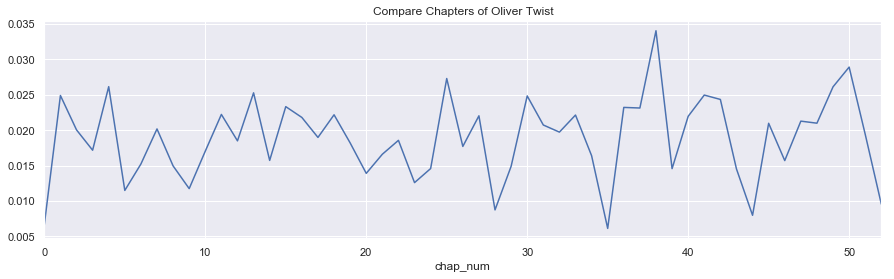

In [33]:
D.tf.plot(figsize=(15,4), title = 'Compare Chapters of Oliver Twist')

In [34]:
chap_ids = D.index.tolist()
pairs = [(i,j) for i in chap_ids for j in chap_ids if j > i]

In [35]:
OT_P = pd.DataFrame(pairs).reset_index(drop=True).set_index([0,1])
OT_P.index.names = ['doc_x','doc_y']

In [36]:
def euclidean(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = (D1 - D2)**2
    y = x.sum() 
    z = np.sqrt(y)
    return z

In [37]:
OT_P['euclidean'] = 0
OT_P['euclidean'] = OT_P.apply(euclidean, 1)

In [38]:
OT_PME = OT_P.euclidean.unstack().fillna(0)

In [39]:
OT_PME.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,52
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.156796,0.169759,0.164316,0.149622,0.176816,0.156535,0.147234,0.152234,0.159673,0.190128,...,0.154988,0.180081,0.142833,0.148707,0.160173,0.155037,0.148917,0.141640,0.146434,0.168692
1,0.000000,0.142335,0.131808,0.125935,0.159880,0.127374,0.124531,0.131077,0.140094,0.174932,...,0.134924,0.163044,0.121919,0.128562,0.140986,0.135406,0.128394,0.118012,0.125034,0.149817
2,0.000000,0.000000,0.145736,0.139240,0.169181,0.140800,0.135974,0.141927,0.149306,0.178508,...,0.145079,0.171848,0.133054,0.138660,0.150692,0.146171,0.138955,0.129895,0.135745,0.160058
3,0.000000,0.000000,0.000000,0.105641,0.156133,0.115443,0.129038,0.135122,0.144166,0.176717,...,0.138682,0.166755,0.126379,0.132451,0.145329,0.139426,0.132756,0.121269,0.128641,0.153287
4,0.000000,0.000000,0.000000,0.000000,0.127324,0.099820,0.109141,0.116952,0.127207,0.164173,...,0.121087,0.143887,0.105929,0.111482,0.127803,0.122244,0.113743,0.104030,0.109536,0.138380


In [40]:
def cosine(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = D1 * D2
    y = x.sum()
    a = np.sqrt(D1.sum()**2)
    b = np.sqrt(D2.sum()**2)
    c = np.sqrt(a) * np.sqrt(b)
    z = y / c
    return z

In [41]:
OT_P['cosine'] = OT_P.apply(cosine, 1)
OT_PMC = OT_P.cosine.unstack().fillna(0)
OT_PMC.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,52
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.000653,0.000313,0.000342,0.000373,0.000306,0.000351,0.000182,0.000173,0.000184,0.000217,...,0.000109,0.000176,0.000206,0.000171,0.000157,0.000202,0.000162,0.000319,0.000167,0.000217
1,0.000000,0.001006,0.001335,0.000580,0.000302,0.001026,0.000297,0.000249,0.000223,0.000174,...,0.000136,0.000211,0.000158,0.000135,0.000171,0.000198,0.000156,0.000429,0.000192,0.000285
2,0.000000,0.000000,0.001074,0.000406,0.000251,0.000825,0.000264,0.000218,0.000269,0.000570,...,0.000138,0.000185,0.000161,0.000177,0.000176,0.000152,0.000162,0.000403,0.000207,0.000210
3,0.000000,0.000000,0.000000,0.002138,0.000885,0.002154,0.000297,0.000265,0.000216,0.000304,...,0.000161,0.000184,0.000162,0.000165,0.000143,0.000204,0.000152,0.000532,0.000249,0.000307
4,0.000000,0.000000,0.000000,0.000000,0.001813,0.001855,0.000362,0.000289,0.000245,0.000247,...,0.000182,0.000919,0.000233,0.000340,0.000214,0.000204,0.000200,0.000367,0.000264,0.000272


## Cosine Similarity

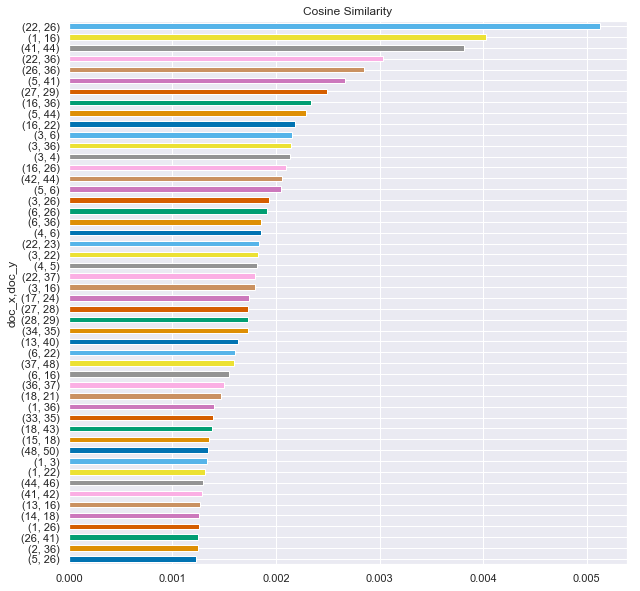

In [42]:
OT_P.cosine.sort_values(ascending=True).tail(50).plot(kind='barh', color=sns.color_palette('colorblind'), figsize=(10,10), title = 'Cosine Similarity')

## Compare Euclidean and Cosine Metrics

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


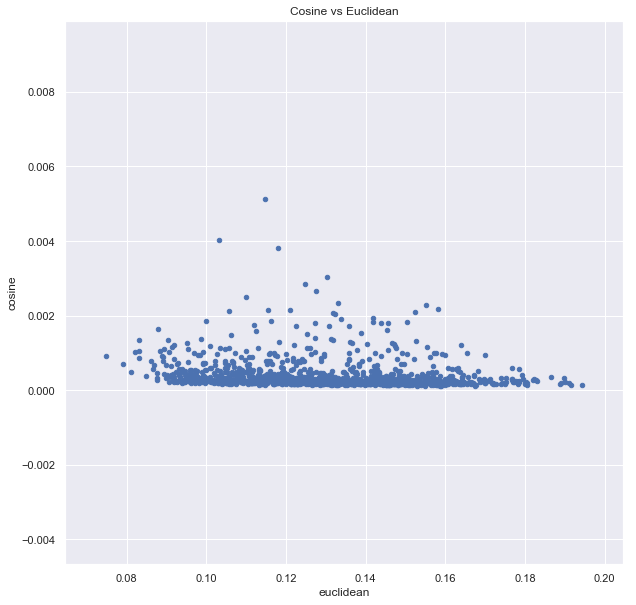

In [43]:
OT_P.plot(kind='scatter', x='euclidean', y='cosine', figsize=(10,10), title='Cosine vs Euclidean')

In [44]:
import matplotlib.pyplot as plt

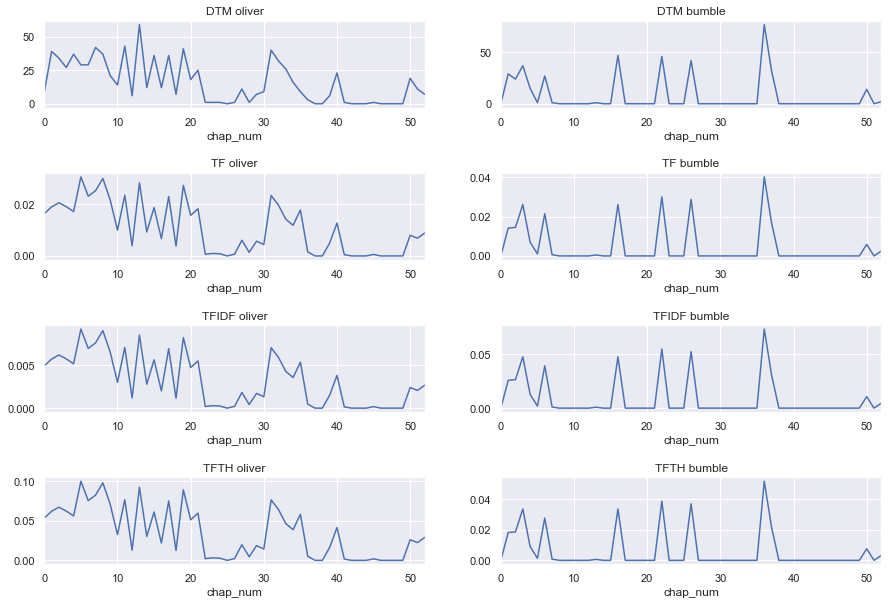

In [45]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('oliver bumble'.split()):
    W = get_term_id(OT_V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)

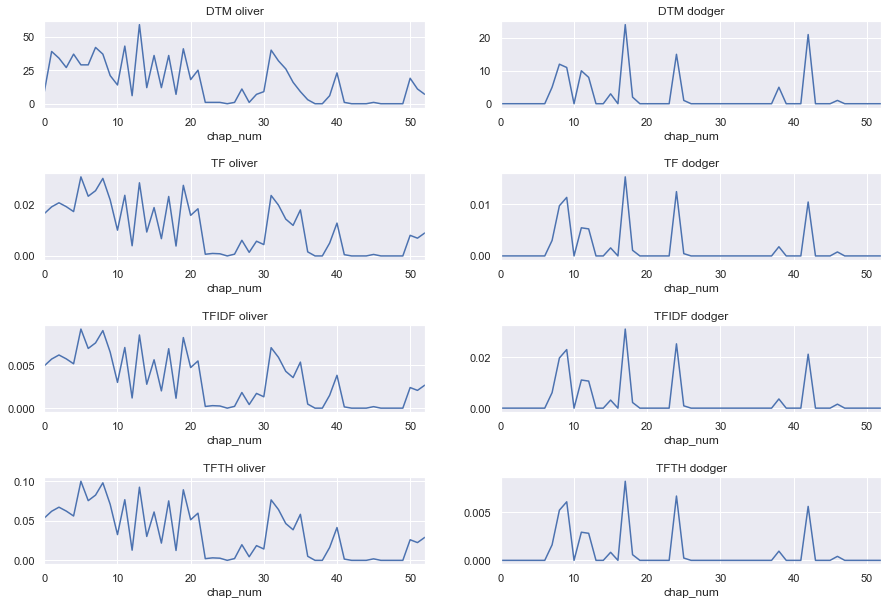

In [47]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('oliver dodger'.split()):
    W = get_term_id(OT_V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)

In [48]:
OT_V.to_csv('Oliver_Twist_V.csv', index=False)

## Visualize KDE Plots

In [49]:
OT_K.head()

pos token_str  punc  num term_str  \
chap_num para_num sent_num token_num                                      
0        0        0        0           NN   CHAPTER     0    0  chapter   
                           1          PRP         I     0    0        i   
         1        0        0           NN    TREATS     0    0   treats   
                           1           IN        OF     0    0       of   
                           2          NNP       THE     0    0      the   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             1916  
                           1             4876  
         1        0        0             9659  
                           1             6506  
                           2             9383

In [50]:
lmk = OT_K.copy()

In [51]:
tt = lmk[['term_str','term_id']]
tt.head()

term_str  term_id
chap_num para_num sent_num token_num                  
0        0        0        0          chapter     1916
                           1                i     4876
         1        0        0           treats     9659
                           1               of     6506
                           2              the     9383

In [52]:
K = tt.reset_index()

In [53]:
K.rename_axis('offset', inplace=True)

In [54]:
K = K[['term_str','term_id']]
K.head(11).T

offset,0,1,2,3,4,5,6,7,8,9,10
term_str,chapter,i,treats,of,the,place,where,oliver,twist,was,born
term_id,1916,4876,9659,6506,9383,7003,10279,6535,9752,10190,1550


In [55]:
vocab_weight = 'tfidf_sum'
vocab_weight_quantile = .94
vocab_min_n = 3
kde_kernel = 'gaussian'
kde_bandwidth = 5000
kde_samples = 1000

In [56]:
V1 = OT_V[(OT_V[vocab_weight] > OT_V[vocab_weight].quantile(vocab_weight_quantile)) & (OT_V.n >= vocab_min_n)]

In [57]:
V1.sort_values(vocab_weight, ascending=False).head(10).T

term_id,1698,8492,6366,1674,3741,4308,5339,6535,6134,2477
term_str,bumble,sikes,noah,brownlow,fagin,giles,jew,oliver,monks,corney
n,395,351,134,171,299,118,321,839,133,65
p,0.00244744,0.00217482,0.000830271,0.00105953,0.00185262,0.000731135,0.00198893,0.00519849,0.000824075,0.000402744
port_stem,bumbl,sike,noah,brownlow,fagin,gile,jew,oliv,monk,corney
stop,0,0,0,0,0,0,0,0,0,0
df,15,21,10,12,26,10,27,43,11,4
tf_sum,0.235425,0.221989,0.103248,0.0949271,0.197597,0.0822469,0.199056,0.562138,0.0719133,0.0434626
tf_mean,0.00444198,0.00418847,0.00194807,0.00179108,0.00372825,0.00155183,0.00375578,0.0106064,0.00135686,0.000820049
tf_max,0.0401667,0.0283996,0.0263432,0.019042,0.031866,0.0269377,0.0311304,0.0305581,0.0282721,0.0198357
tfidf_sum,0.428716,0.296489,0.248414,0.203425,0.203027,0.197885,0.193688,0.169572,0.163135,0.162025


In [58]:
TOP_TERMS = OT_V.sort_values(vocab_weight, ascending=False).term_str.head(30).tolist()

In [59]:
TOP_TERMS

['bumble',
 'sikes',
 'noah',
 'brownlow',
 'fagin',
 'giles',
 'jew',
 'oliver',
 'monks',
 'corney',
 'mrs',
 'dodger',
 'sowerberry',
 'mann',
 'yer',
 'doctor',
 'bates',
 'harry',
 'beadle',
 'mr',
 'matron',
 'girl',
 'grimwig',
 'nancy',
 'fang',
 'maylie',
 'brittles',
 'charley',
 'toby',
 'sir']

In [60]:
K = K[K.term_id.isin(V1.index)]

In [61]:
K.head(11).T

offset,7,8,10,14,17,18,20,24,25,46,51
term_str,oliver,twist,born,circumstances,birth,among,public,certain,town,name,common
term_id,6535,9752,1550,2025,1414,820,7398,1881,9599,6260,2192


In [62]:
B = K.reset_index().groupby(['term_str']).offset.apply(lambda x: x.tolist()).to_frame()

In [63]:
B['x'] = B.apply(lambda x: np.array(x.offset)[:, np.newaxis], 1)

In [64]:
B.head()

,offset,x
term_str,,
'ah,"[778, 2536, 10544, 12962, 13946, 15013, 16592,...","[[778], [2536], [10544], [12962], [13946], [15..."
'but,"[3082, 12399, 12974, 23859, 26961, 31180, 4574...","[[3082], [12399], [12974], [23859], [26961], [..."
'come,"[6608, 6638, 7037, 7059, 11888, 12863, 14869, ...","[[6608], [6638], [7037], [7059], [11888], [128..."
'd,"[6684, 7596, 9329, 9421, 11851, 15964, 16130, ...","[[6684], [7596], [9329], [9421], [11851], [159..."
'em,"[642, 1986, 2538, 2553, 6201, 6262, 6287, 9381...","[[642], [1986], [2538], [2553], [6201], [6262]..."


In [65]:
from sklearn.neighbors import KernelDensity as KDE
scale_max = K.index.max()
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

In [66]:
B.head()

,offset,x,kde,scores
term_str,,,,
'ah,"[778, 2536, 10544, 12962, 13946, 15013, 16592,...","[[778], [2536], [10544], [12962], [13946], [15...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-12.329357702466577, -12.313350970804962, -12..."
'but,"[3082, 12399, 12974, 23859, 26961, 31180, 4574...","[[3082], [12399], [12974], [23859], [26961], [...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-13.889675481231638, -13.864627104771955, -13..."
'come,"[6608, 6638, 7037, 7059, 11888, 12863, 14869, ...","[[6608], [6638], [7037], [7059], [11888], [128...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-12.52697539281961, -12.480905796192753, -12...."
'd,"[6684, 7596, 9329, 9421, 11851, 15964, 16130, ...","[[6684], [7596], [9329], [9421], [11851], [159...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-13.462782879202859, -13.410794766705497, -13..."
'em,"[642, 1986, 2538, 2553, 6201, 6262, 6287, 9381...","[[642], [1986], [2538], [2553], [6201], [6262]...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-12.023606755999403, -11.995186283891258, -11..."


In [67]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1)

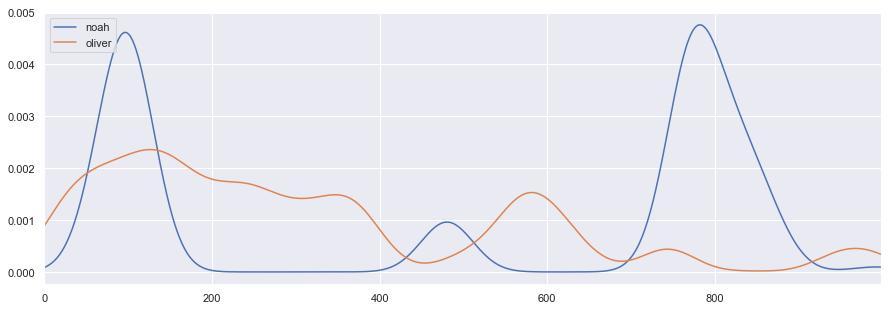

In [68]:
FIG = dict(figsize=(15, 5))
PLOTS.loc['noah'].plot(**FIG)
PLOTS.loc['oliver'].plot(**FIG)
plt.legend(loc='upper left') 

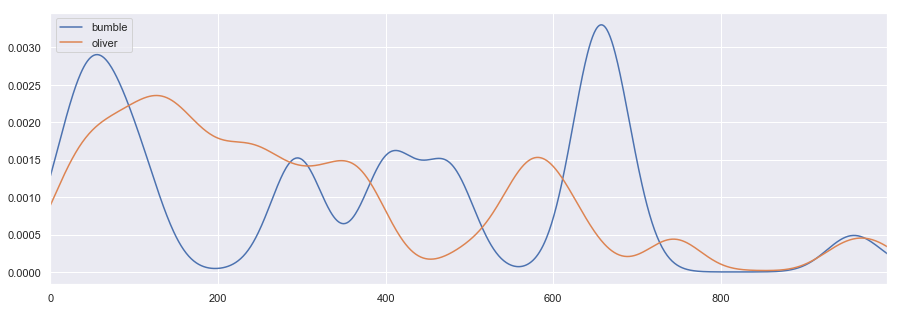

In [69]:
PLOTS.loc['bumble'].plot(**FIG)
PLOTS.loc['oliver'].plot(**FIG)
plt.legend(loc='upper left') 

## Compute TFIDF

In [72]:
WORDS = (OT_K.punc == 0) & (OT_K.num == 0) & OT_K.term_id.isin(OT_V[OT_V.stop==0].index)

In [73]:
BOW = OT_K[WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()

In [74]:
DTM = BOW.unstack().fillna(0)

In [75]:
alpha = .000001 
alpha_sum = alpha * OT_V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [76]:
N_docs = DTM.shape[0]
OT_V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / OT_V[OT_V.stop==0]['df'])

In [77]:
TFIDF.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,10574,10575,10576,10577,10582,10583,10584,10585,10586,10587
chap_num,,,,,,,,,,,,,,,,,,,,,
0,1.041420e-08,1.041420e-08,1.041420e-08,6.777908e-09,1.041420e-08,1.041420e-08,7.532508e-09,1.041420e-08,1.041420e-08,1.970990e-03,...,5.714360e-09,8.596056e-09,8.596056e-09,1.041420e-08,5.310018e-09,6.192596e-09,1.041420e-08,1.041420e-08,8.596056e-09,1.041420e-08
1,2.785939e-09,2.785939e-09,2.785939e-09,1.813182e-09,2.785939e-09,2.785939e-09,2.015047e-09,2.785939e-09,2.785939e-09,5.272665e-04,...,1.528668e-09,2.299561e-09,2.299561e-09,2.785939e-09,1.420503e-03,1.656603e-09,2.785939e-09,2.785942e-03,2.299561e-09,2.785939e-09
2,3.460957e-09,3.460957e-09,3.460957e-09,2.252506e-09,3.460957e-09,3.460957e-09,2.503282e-09,3.460957e-09,3.460957e-09,6.550196e-10,...,1.899056e-09,2.856731e-09,2.856731e-09,3.460957e-09,1.764683e-03,2.057988e-09,3.460957e-09,3.460957e-09,2.856731e-09,3.460957e-09
3,4.039406e-09,4.039406e-09,4.039406e-09,2.628980e-09,4.039406e-09,4.039406e-09,2.921670e-09,4.039406e-09,4.039406e-09,7.644974e-04,...,2.216456e-09,3.334193e-09,3.334193e-09,4.039406e-09,2.059622e-09,2.401952e-09,4.039406e-09,4.039406e-09,3.334193e-09,4.039406e-09
4,2.653030e-09,2.653030e-09,2.653030e-09,1.726680e-09,2.653030e-09,2.653030e-09,1.918915e-09,2.653030e-09,2.653030e-09,1.506335e-03,...,1.455740e-09,2.189855e-09,2.189855e-09,2.653030e-09,1.352735e-03,1.577571e-09,2.653030e-09,2.653030e-09,2.189855e-09,2.653030e-09


## Principal Component Analysis

In [78]:
def get_pca(df, k=2):
    from sklearn.decomposition import PCA
    pca = PCA(k)
    X = pd.DataFrame(pca.fit_transform(df))
    X.index = df.index.tolist()
    return X

In [79]:
pca1 = get_pca(TFIDF, k=2)
pca1

,0,1
0,-0.003990,-0.009068
1,0.039208,-0.016136
2,0.021144,-0.009765
3,0.046386,0.000956
4,0.015731,0.021634
5,0.009900,0.076692
6,0.035296,0.020859
7,-0.007651,-0.000924
8,-0.014301,0.001155
9,-0.014477,-0.001697


In [80]:
X = np.array(pca1)
X

array([[-0.00398992, -0.0090676 ],
       [ 0.03920793, -0.01613606],
       [ 0.0211439 , -0.00976496],
       [ 0.046386  ,  0.00095573],
       [ 0.01573091,  0.02163385],
       [ 0.00990025,  0.07669208],
       [ 0.03529556,  0.02085881],
       [-0.00765093, -0.00092372],
       [-0.01430128,  0.00115547],
       [-0.01447721, -0.00169734],
       [-0.01469779, -0.0197043 ],
       [-0.0071954 , -0.00476306],
       [-0.0153019 ,  0.00051097],
       [-0.00424862, -0.01106983],
       [-0.01500897,  0.00148844],
       [-0.01664618,  0.00158929],
       [ 0.06129788, -0.02322274],
       [-0.0163028 ,  0.00291948],
       [-0.01889235,  0.00140932],
       [-0.0130329 , -0.00119329],
       [-0.0145514 , -0.00294497],
       [-0.01725763,  0.00102287],
       [ 0.09000869, -0.01109355],
       [ 0.00710099, -0.00559633],
       [-0.02050389,  0.0060734 ],
       [-0.01181804,  0.00058473],
       [ 0.08354425,  0.01203242],
       [-0.01905343, -0.02094508],
       [-0.0128783 ,

In [81]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [82]:
print(pca.components_)

[[1. 0.]
 [0. 1.]]


In [83]:
print(pca.explained_variance_)

[0.00068131 0.00049614]


In [84]:
print(pca.mean_)

[ 1.03101490e-18 -6.21882001e-19]


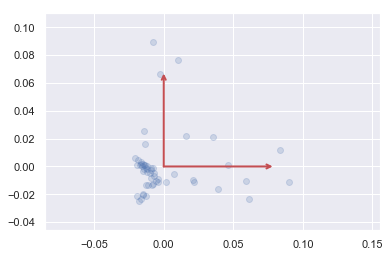

In [85]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='r')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

## Sentiment Analysis

In [86]:
import sqlite3

In [87]:
# Developed in other notebook
lex_db = 'lexicon/lexicons.db'

In [88]:
text_db = 'db/Oliver_Twist.db'
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

emo = 'bing_sentiment'
#emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

In [89]:
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

In [90]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')

In [91]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-1.0
abate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
abdicate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0


In [92]:
emo_cols = combo.columns

In [93]:
emo_cols

Index(['nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'bing_negative', 'bing_positive', 'bing_sentiment',
       'gi_sentiment'],
      dtype='object')

In [94]:
with sqlite3.connect(text_db) as db:
    tokens = pd.read_sql("SELECT * FROM token WHERE punc = 0", db, index_col=OHCO)
    vocab = pd.read_sql("SELECT * FROM vocab", db, index_col='term_id')

In [95]:
tokens = tokens.join(combo, on='term_str', how='left')

In [96]:
tokens[emo].sample(10)

chap_num  para_num  sent_num  token_num
47        40        0         34          NaN
51        40        1         11          NaN
30        64        8         32          NaN
21        6         2         18          NaN
24        14        2         7           NaN
22        21        5         6           NaN
40        52        1         9           NaN
11        43        0         22          NaN
19        44        0         24          NaN
1         70        0         4           NaN
Name: bing_sentiment, dtype: float64

In [97]:
tokens[emo_cols] = tokens[emo_cols].fillna(0)

In [98]:
tokens.head(10)

pos token_str  punc  num term_str  \
chap_num para_num sent_num token_num                                      
0        0        0        0           NN   CHAPTER     0    0  chapter   
                           1          PRP         I     0    0        i   
         1        0        0           NN    TREATS     0    0   treats   
                           1           IN        OF     0    0       of   
                           2          NNP       THE     0    0      the   
                           3          NNP     PLACE     0    0    place   
                           4          NNP     WHERE     0    0    where   
                           5          NNP    OLIVER     0    0   oliver   
                           6          NNP     TWIST     0    0    twist   
                           7          NNP       WAS     0    0      was   

                                      term_id  nrc_anger  nrc_anticipation  \
chap_num para_num sent_num token_num                                         
0        0        0        0             1410        0.0               0.0   
                           1             4405        0.0               0.0   
         1        0        0             9218        0.0               0.0   
                           1             6046        0.0               0.0   
                           2             8938        0.0               0.0   
                           3             6545        0.0               0.0   
                           4             9844        0.0               0.0   
                           5             6074        0.0               0.0   
                           6             9311        0.0               0.0   
                           7             9753        0.0               0.0   

                                      nrc_disgust  nrc_fear  nrc_joy  \
chap_num para_num sent_num token_num                                   
0        0        0        0                  0.0       0.0      0.0   
                           1                  0.0       0.0      0.0   
         1        0        0                  0.0       0.0      0.0   
                           1                  0.0       0.0      0.0   
                           2                  0.0       0.0      0.0   
                           3                  0.0       0.0      0.0   
                           4                  0.0       0.0      0.0   
                           5                  0.0       0.0      0.0   
                           6                  0.0       0.0      0.0   
                           7                  0.0       0.0      0.0   

                                      nrc_negative  nrc_positive  nrc_sadness  \
chap_num para_num sent_num token_num                                            
0        0        0        0                   0.0           0.0          0.0   
                           1                   0.0           0.0          0.0   
         1        0        0                   0.0           0.0          0.0   
                           1                   0.0           0.0          0.0   
                           2                   0.0           0.0          0.0   
                           3                   0.0           0.0          0.0   
                           4                   0.0           0.0          0.0   
                           5                   0.0           0.0          0.0   
                           6                   0.0           0.0          0.0   
                           7                   0.0           0.0          0.0   

                                      nrc_surprise  nrc_trust  bing_negative  \
chap_num para_num sent_num token_num                                           
0        0        0        0                   0.0        0.0            0.0   
                           1                   0.0        0.0            0.0   
         1        0        0              

In [99]:
FIG = dict(figsize=(20, 5), legend=True, fontsize=14, rot=45)

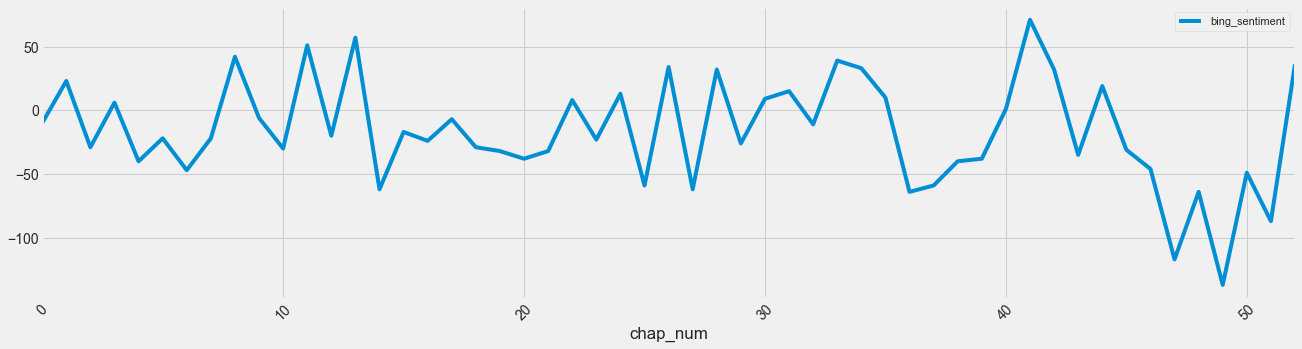

In [100]:
tokens.groupby(CHAPS)[emo].sum().plot(**FIG)

In [101]:
by_chaps= tokens.groupby(CHAPS)[emo_cols].sum()

In [102]:
tokens['html'] =  tokens.apply(lambda x: 
                               "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)

In [103]:
tokens['html'].head()

chap_num  para_num  sent_num  token_num
0         0         0         0            <span class='sent0'>CHAPTER</span>
                              1                  <span class='sent0'>I</span>
          1         0         0             <span class='sent0'>TREATS</span>
                              1                 <span class='sent0'>OF</span>
                              2                <span class='sent0'>THE</span>
Name: html, dtype: object

In [104]:
by_chaps['chaps_str'] = tokens.groupby(CHAPS).term_str.apply(lambda x: x.str.cat(sep=' '))
by_chaps['html_str'] = tokens.groupby(CHAPS).html.apply(lambda x: x.str.cat(sep=' '))

In [105]:
by_chaps[['chaps_str', 'html_str']].head()

,chaps_str,html_str
chap_num,,
0,chapter i treats of the place where oliver twi...,<span class='sent0'>CHAPTER</span> <span class...
1,chapter ii treats of oliver twist s growth edu...,<span class='sent0'>CHAPTER</span> <span class...
2,chapter iii relates how oliver twist was very ...,<span class='sent0'>CHAPTER</span> <span class...
3,chapter iv oliver being offered another place ...,<span class='sent0'>CHAPTER</span> <span class...
4,chapter v oliver mingles with new associates g...,<span class='sent0'>CHAPTER</span> <span class...


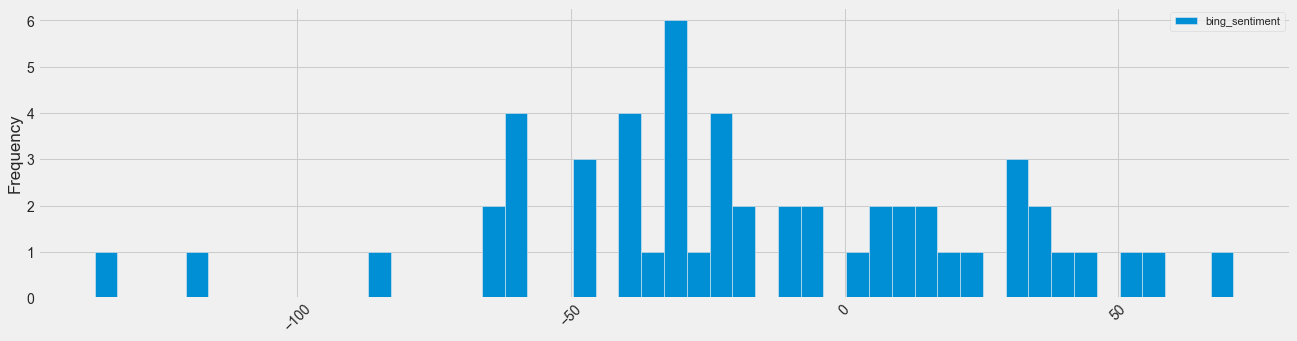

In [106]:
by_chaps[emo].plot.hist(**FIG, bins=50)

### Positive

In [107]:
by_chaps.sort_values(emo, ascending=False)[[emo,'chaps_str']].head(20)

,bing_sentiment,chaps_str
chap_num,,
41,71.0,chapter xlii an old acquaintance of oliver s e...
13,57.0,chapter xiv comprising further particulars of ...
11,51.0,chapter xii in which oliver is taken better ca...
8,42.0,chapter ix containing further particulars conc...
33,39.0,chapter xxxiv contains some introductory parti...
52,36.0,chapter liii and last the fortunes of those wh...
26,34.0,chapter xxvii atones for the unpoliteness of a...
34,33.0,chapter xxxv containing the unsatisfactory res...
42,32.0,chapter xliii wherein is shown how the artful ...


### Negative

In [108]:
by_chaps.sort_values(emo, ascending=True)[[emo,'chaps_str']].head(20)

,bing_sentiment,chaps_str
chap_num,,
49,-137.0,chapter l the pursuit and escape near to that ...
47,-117.0,chapter xlviii the flight of sikes of all bad ...
51,-87.0,chapter lii fagin s last night alive the court...
36,-64.0,chapter xxxvii in which the reader may perceiv...
48,-64.0,chapter xlix monks and mr brownlow at length m...
27,-62.0,chapter xxviii looks after oliver and proceeds...
14,-62.0,chapter xv showing how very fond of oliver twi...
25,-59.0,chapter xxvi in which a mysterious character a...
37,-59.0,chapter xxxviii containing an account of what ...


### Multinomial Emotions

In [109]:
EOM = tokens[emo_cols].reset_index(drop=True)

In [110]:
EOM.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,gi_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


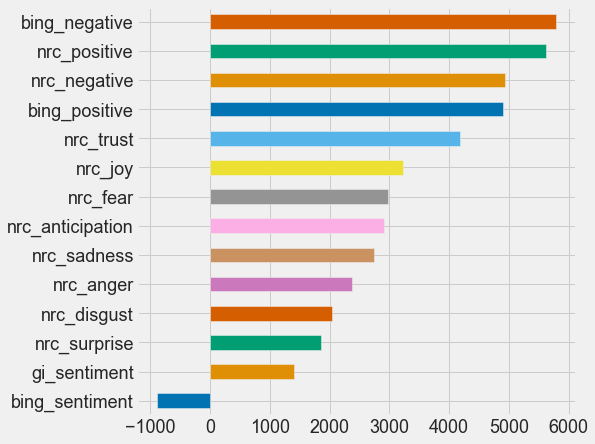

In [111]:
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18, color=sns.color_palette('colorblind'))

### Visualize KDE for Emotions

In [112]:
emo_offsets = []
for col in emo_cols:
    x = EOM[EOM[col] > 0].index.tolist()
    y = [[i] for i in x]
    emo_offsets.append((col, y))
B = pd.DataFrame(emo_offsets, columns=['emo', 'x'])
B = B.set_index('emo')

In [113]:
B.head()

,x
emo,
nrc_anger,"[[105], [148], [184], [268], [281], [452], [52..."
nrc_anticipation,"[[17], [20], [144], [211], [337], [447], [505]..."
nrc_disgust,"[[184], [452], [583], [899], [1083], [1601], [..."
nrc_fear,"[[17], [105], [128], [141], [148], [155], [184..."
nrc_joy,"[[17], [144], [378], [447], [505], [525], [554..."


In [114]:
scale_max = EOM.shape[0]
kde_bandwidth = 2500
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

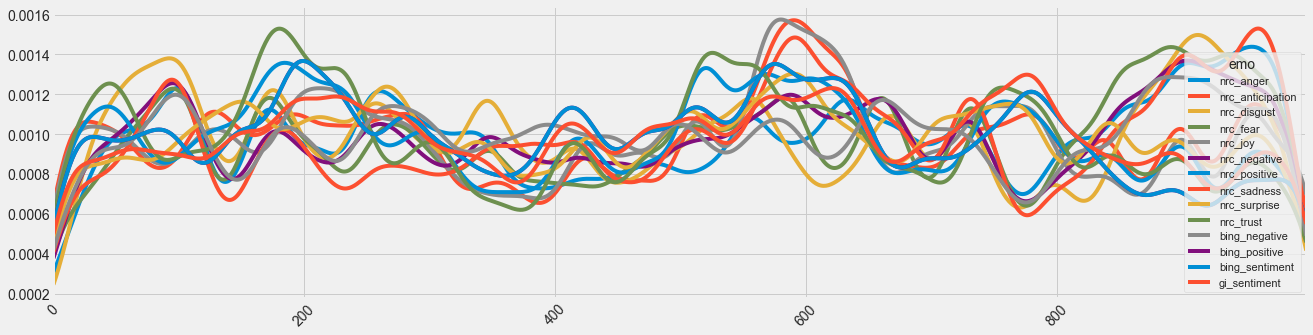

In [115]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1).T
PLOTS.plot(**FIG)

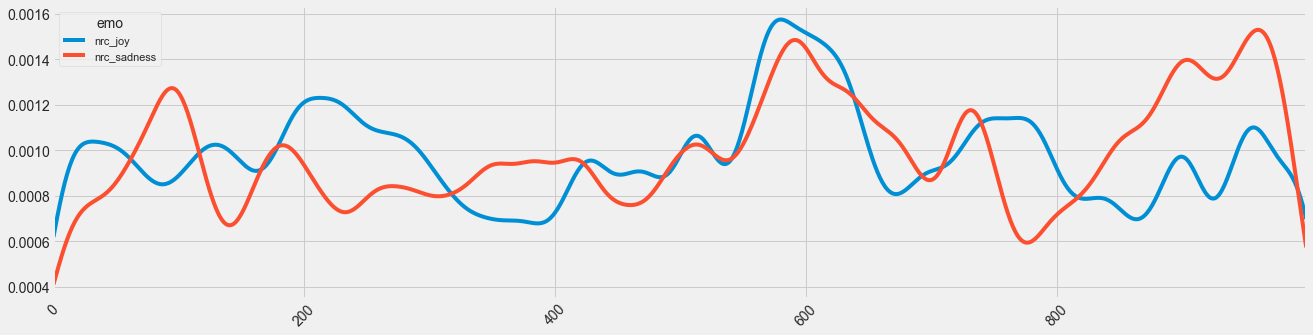

In [116]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)

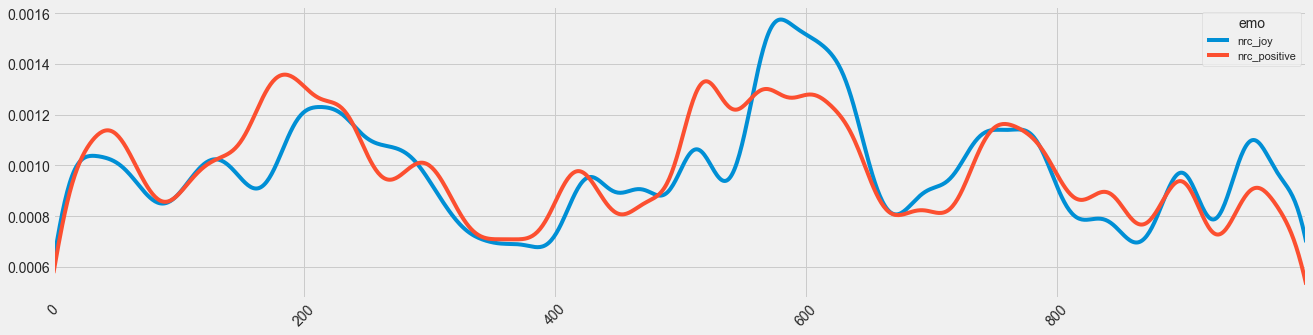

In [117]:
PLOTS[['nrc_joy','nrc_positive']].plot(**FIG)

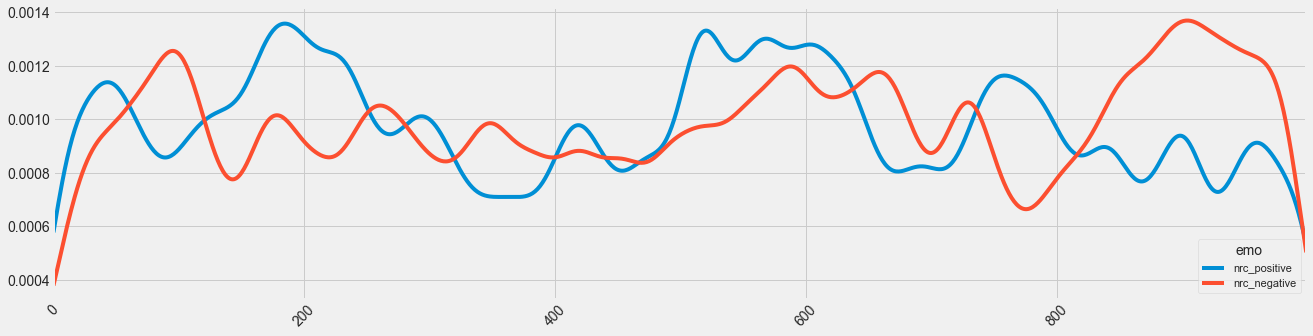

In [118]:
PLOTS[['nrc_positive','nrc_negative']].plot(**FIG)

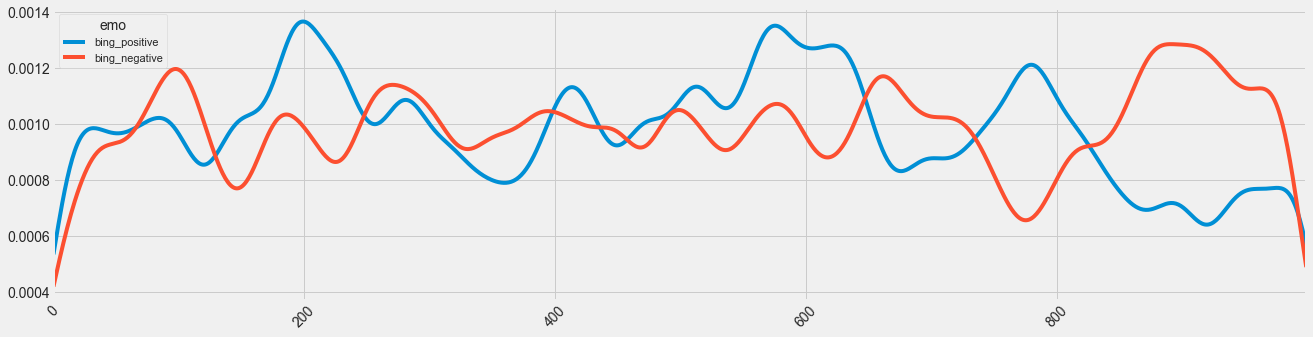

In [119]:
PLOTS[['bing_positive','bing_negative']].plot(**FIG)